<font size="6">**Technical Indicators**</font>

In [1]:

import numpy as np
import seaborn as sns

from sklearn.model_selection import (TimeSeriesSplit, cross_validate)
from sklearn.linear_model import LinearRegression

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%run ../nb_config.py

running notebook configuration


In [4]:
from src.load_data import market_data
from src.mle import time_series as mle_ts
from src import utils

# Parameters

In [5]:
TAU_TARGET = 5
KFOLDS = 3
SPLIT_DT = '2019-12-31'

# Load Data

In [6]:
comm_df = market_data.read_mkt_data()[['brent']]
target = mle_ts.get_targets(y=comm_df[['brent']], tau=TAU_TARGET).rename(columns={'brent':'target'})

comm_df = comm_df.join(target, how='inner')

In [7]:
from scipy.stats import spearmanr

def compute_spearman(y_true, y_pred):

    return spearmanr(y_true, y_pred, nan_policy='omit').correlation

In [8]:
from sklearn.metrics import fbeta_score, make_scorer
spearman_scorer = make_scorer(compute_spearman, greater_is_better=True)

# Split Data

In [9]:
X_train = comm_df.loc[:SPLIT_DT, ['brent']]
y_train = target.loc[:SPLIT_DT, 'target']

In [10]:
tscv = TimeSeriesSplit(n_splits=KFOLDS)
sp_tscv  = tscv.split(y_train)


# MACD

## Example

In [11]:
comm_df['brent_mave5'] = comm_df['brent'].rolling(5, min_periods=1).mean()
comm_df['brent_mave20'] = comm_df['brent'].rolling(20, min_periods=1).mean()
comm_df['x_brent_macd'] = comm_df['brent_mave5'] - comm_df['brent_mave20']

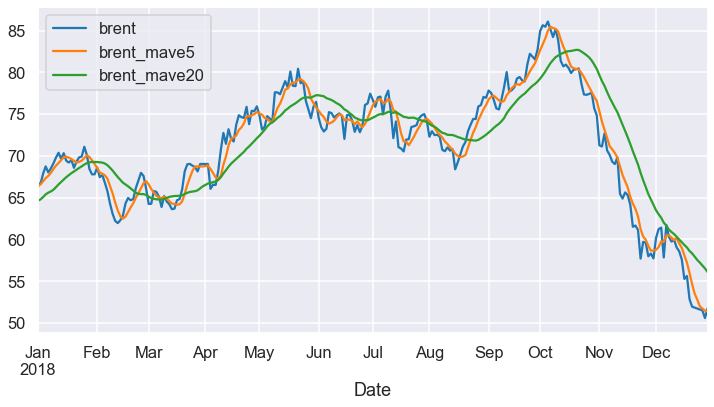

In [12]:
comm_df['2018'].plot(y=['brent', 'brent_mave5', 'brent_mave20'])
plt.show()

In [13]:
comm_df[['x_brent_macd', 'target']].corr('spearman')

,x_brent_macd,target
x_brent_macd,1.0000,0.1818
target,0.1818,1.0000


In [14]:
pd.crosstab(comm_df['x_brent_macd']>0, comm_df['target']>0, normalize=True)

target,False,True
x_brent_macd,,
False,0.2080,0.1829
True,0.2146,0.3945


In [15]:
compute_spearman(comm_df['x_brent_macd'] , comm_df['target'])

0.18179226264069234

## Tunning

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

from src.mle import time_series as mle_ts

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import KBinsDiscretizer



In [17]:
macd_zscored = mle_ts.MACD().fit_transform(X_train)

In [18]:
(macd_zscored.iloc[:,0]>0).value_counts()

True     537
False    500
Name: 0, dtype: int64

In [19]:
mle_ts.run_adf_test(macd_zscored)

,adf,pvalue
0,-5.9226,0.0000


In [20]:
from src.mle import time_series as mle_ts

lr = LinearRegression(fit_intercept=False)
fte_macd = mle_ts.MACD()
discr = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
pl_macd = Pipeline([('macd', fte_macd), ('discr', discr), ('lr', lr)])


grid_macd = {'macd__short_tau': [3, 5, 10, 15],
             'macd__long_tau': [20, 30, 40, 50, 60],
            'macd__zscore_tau': [60, 90, 120]}

macd_gcv = GridSearchCV(pl_macd, grid_macd, scoring=spearman_scorer, cv=tscv, n_jobs=-1)
macd_gcv.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             estimator=Pipeline(steps=[('macd', MACD()),
                                       ('discr',
                                        KBinsDiscretizer(encode='ordinal',
                                                         n_bins=10,
                                                         strategy='uniform')),
                                       ('lr',
                                        LinearRegression(fit_intercept=False))]),
             n_jobs=-1,
             param_grid={'macd__long_tau': [20, 30, 40, 50, 60],
                         'macd__short_tau': [3, 5, 10, 15],
                         'macd__zscore_tau': [60, 90, 120]},
             scoring=make_scorer(compute_spearman))

In [21]:
macd_cv_res = pd.DataFrame(macd_gcv.cv_results_)
macd_cv_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_macd__long_tau,param_macd__short_tau,param_macd__zscore_tau,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.0424,0.0068,0.0140,0.0022,20,3,60,"{'macd__long_tau': 20, 'macd__short_tau': 3, '...",0.1843,0.3325,0.1208,0.2125,0.0887,3
1,0.0236,0.0073,0.0130,0.0014,20,3,90,"{'macd__long_tau': 20, 'macd__short_tau': 3, '...",0.1994,0.3124,0.1309,0.2142,0.0748,1
2,0.0176,0.0024,0.0116,0.0005,20,3,120,"{'macd__long_tau': 20, 'macd__short_tau': 3, '...",0.1796,0.3167,0.1430,0.2131,0.0748,2
3,0.0199,0.0043,0.0116,0.0005,20,5,60,"{'macd__long_tau': 20, 'macd__short_tau': 5, '...",0.0979,0.2366,0.0418,0.1255,0.0819,21
4,0.0193,0.0026,0.0120,0.0000,20,5,90,"{'macd__long_tau': 20, 'macd__short_tau': 5, '...",0.0790,0.2376,0.0816,0.1328,0.0742,18


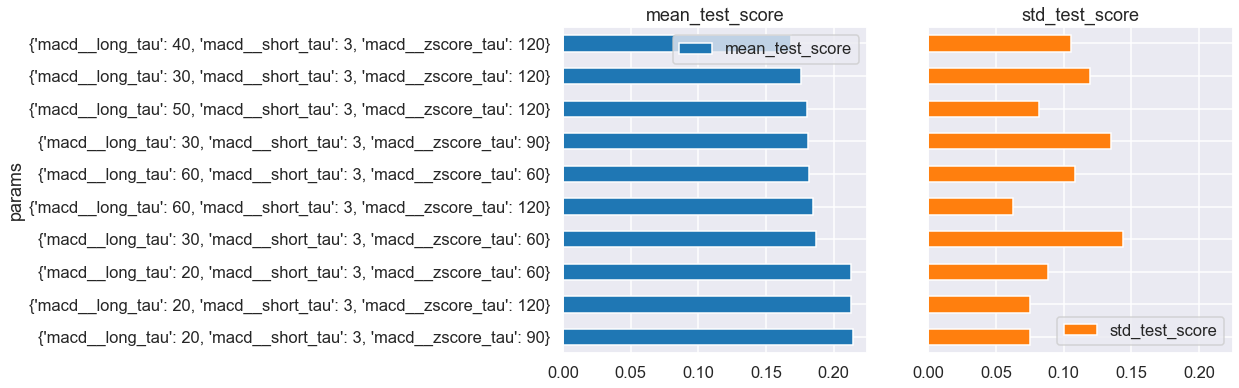

In [22]:
macd_cv_res.sort_values(by='rank_test_score').iloc[:10].\
    plot.barh(x='params', y=['mean_test_score', 'std_test_score'], subplots=True, layout=(1,2), sharey=True)
plt.show()

## Evaluation

In [23]:
fte_macd = mle_ts.MACD(short_tau=3, long_tau=29, zscore_tau=90)
comm_df['x_brent_macd_hpt'] = fte_macd.fit_transform(comm_df[['brent']]).values[:,0]

In [24]:
comm_df[['x_brent_macd_hpt', 'target']].corr('spearman')

,x_brent_macd_hpt,target
x_brent_macd_hpt,1.0000,0.2803
target,0.2803,1.0000


In [25]:
comm_df[['x_brent_macd_hpt', 'target']].corr('spearman')

,x_brent_macd_hpt,target
x_brent_macd_hpt,1.0000,0.2803
target,0.2803,1.0000


In [26]:
pd.crosstab(comm_df['x_brent_macd_hpt']>0, comm_df['target']>0, normalize=True)

target,False,True
x_brent_macd_hpt,,
False,0.2544,0.2242
True,0.1681,0.3532


# Bollinger Bands

In [27]:
from src.mle import time_series as mle_ts

In [28]:
bbands = lambda x: [np.sign(ex) if abs(ex)>=2 else 0 for ex in x]

roll = pd.DataFrame(comm_df[['brent']]).rolling(60, min_periods=1)
mu = roll.mean()
std = roll.std()
zscore = (comm_df[['brent']] - mu)/std
zscore.fillna(method='bfill', inplace=True)


In [29]:
bbands = mle_ts.BBands().fit_transform(comm_df[['brent']])

In [30]:
mle_ts.run_adf_test(bbands)

,adf,pvalue
0,-8.3991,0.0000


## Tunning

In [31]:
lr = LinearRegression(fit_intercept=False)
fte_bb = mle_ts.BBands()
discr = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
pl_bb = Pipeline([('bb', fte_bb), ('discr', discr), ('lr', lr)])


grid_bb = {'bb__win_size': [30, 60, 120], 'bb__threshold': [1.5, 1.75, 2.]}

bb_gcv = GridSearchCV(pl_bb, grid_bb, scoring=spearman_scorer, cv=tscv, n_jobs=-1)
bb_gcv.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             estimator=Pipeline(steps=[('bb', BBands()),
                                       ('discr',
                                        KBinsDiscretizer(encode='ordinal',
                                                         n_bins=10,
                                                         strategy='uniform')),
                                       ('lr',
                                        LinearRegression(fit_intercept=False))]),
             n_jobs=-1,
             param_grid={'bb__threshold': [1.5, 1.75, 2.0],
                         'bb__win_size': [30, 60, 120]},
             scoring=make_scorer(compute_spearman))

In [32]:
bb_cv_res = pd.DataFrame(bb_gcv.cv_results_)
bb_cv_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bb__threshold,param_bb__win_size,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.0153,0.0005,0.0100,0.0000,1.5000,30,"{'bb__threshold': 1.5, 'bb__win_size': 30}",0.2397,0.2745,0.2713,0.2618,0.0157,1
1,0.0176,0.0033,0.0103,0.0005,1.5000,60,"{'bb__threshold': 1.5, 'bb__win_size': 60}",0.1668,0.3099,0.2125,0.2297,0.0597,4
2,0.0200,0.0053,0.0103,0.0005,1.5000,120,"{'bb__threshold': 1.5, 'bb__win_size': 120}",0.0403,0.2672,0.0375,0.1150,0.1077,7
3,0.0145,0.0004,0.0120,0.0000,1.7500,30,"{'bb__threshold': 1.75, 'bb__win_size': 30}",0.2397,0.2745,0.2713,0.2618,0.0157,1
4,0.0138,0.0008,0.0096,0.0005,1.7500,60,"{'bb__threshold': 1.75, 'bb__win_size': 60}",0.1668,0.3099,0.2125,0.2297,0.0597,4


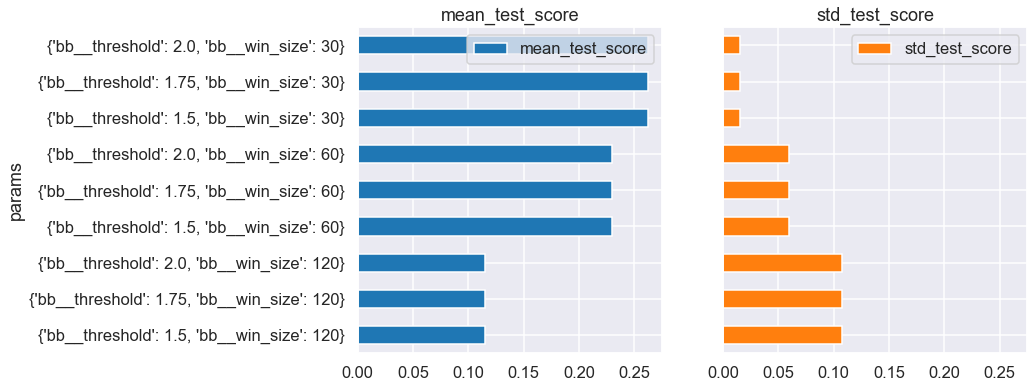

In [33]:
bb_cv_res.sort_values(by='mean_test_score').plot.barh(x='params', y=['mean_test_score', 'std_test_score'], subplots=True, layout=(1,2), sharey=True)
plt.show()

## Evaluation

In [34]:
fte_bb = mle_ts.BBands(win_size=30, threshold=2.)
comm_df['x_brent_bb_hpt'] = fte_bb.fit_transform(comm_df[['brent']]).values[:,0]

In [35]:
comm_df[['x_brent_bb_hpt', 'target']].corr('spearman')

,x_brent_bb_hpt,target
x_brent_bb_hpt,1.0000,0.2876
target,0.2876,1.0000


# Momentum

## Example

In [36]:
from src.mle import time_series as mle_ts

In [37]:
momentum = mle_ts.Momentum().fit_transform(comm_df[['brent']])

<AxesSubplot:>

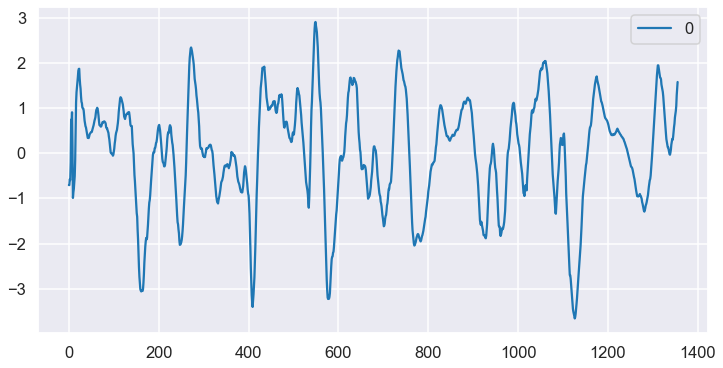

In [38]:
momentum.plot()

In [39]:
mle_ts.run_adf_test(momentum)

,adf,pvalue
0,-8.8503,0.0000


In [40]:
from src.mle import time_series as mle_ts

lr = LinearRegression(fit_intercept=False)
fte_mom = mle_ts.Momentum()
discr = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
pl_mom = Pipeline([('mom', fte_mom), ('discr', discr), ('lr', lr)])


grid_mom = {'mom__tau': [10, 20, 30, 40, 50, 60, 80, 90],
           'mom__zscore_tau': [30, 60, 120],
            'mom__degree': [1,2]}

mom_cv = GridSearchCV(pl_mom, grid_mom, scoring=spearman_scorer, cv=tscv, n_jobs=-1)
mom_cv.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             estimator=Pipeline(steps=[('mom', Momentum()),
                                       ('discr',
                                        KBinsDiscretizer(encode='ordinal',
                                                         n_bins=10,
                                                         strategy='uniform')),
                                       ('lr',
                                        LinearRegression(fit_intercept=False))]),
             n_jobs=-1,
             param_grid={'mom__degree': [1, 2],
                         'mom__tau': [10, 20, 30, 40, 50, 60, 80, 90],
                         'mom__zscore_tau': [30, 60, 120]},
             scoring=make_scorer(compute_spearman))

In [41]:


mom_cv_res= pd.DataFrame(mom_cv.cv_results_)
mom_cv_res.head()

mom_cv_res1 = mom_cv_res.loc[mom_cv_res['param_mom__degree']==1]
mom_cv_res2 = mom_cv_res.loc[mom_cv_res['param_mom__degree']==2]

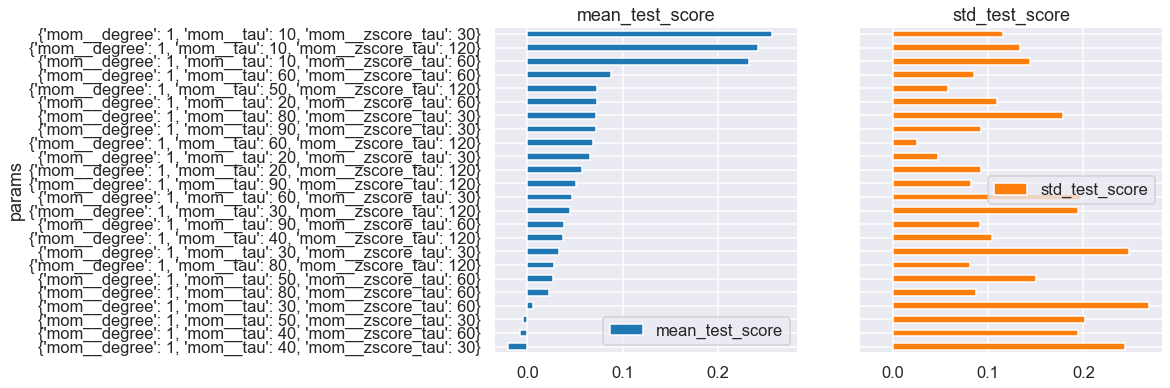

In [42]:
mom_cv_res1.sort_values(by='mean_test_score').plot.barh(x='params', y=['mean_test_score', 'std_test_score'], subplots=True, layout=(1,2), sharey=True)
plt.show()

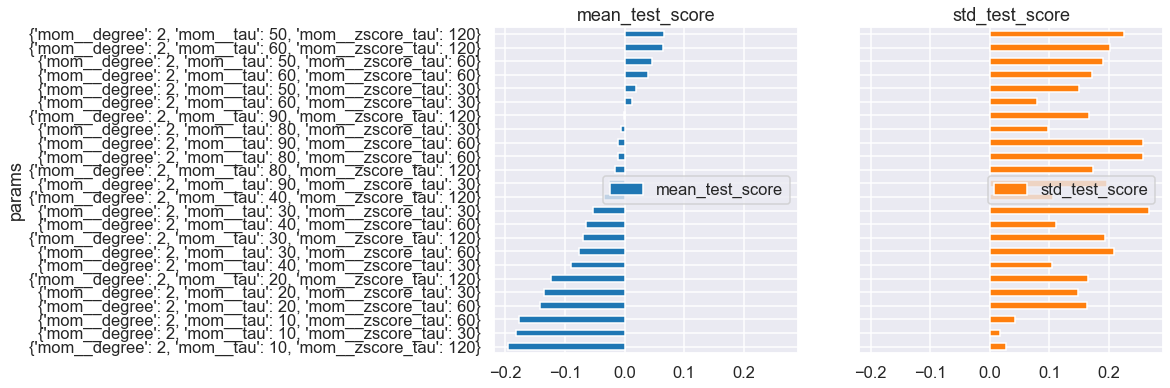

In [43]:
mom_cv_res2.sort_values(by='mean_test_score').plot.barh(x='params', y=['mean_test_score', 'std_test_score'], subplots=True, layout=(1,2), sharey=True)
plt.show()

## Evaluation

In [44]:
fte_mom1 = mle_ts.Momentum(tau=10, zscore_tau=30, degree=1)
comm_df['x_brent_mom1_hpt'] = fte_mom1.fit_transform(comm_df[['brent']]).values[:,0]

In [45]:
comm_df[['x_brent_mom1_hpt', 'target']].corr('spearman')

,x_brent_mom1_hpt,target
x_brent_mom1_hpt,1.0000,0.2898
target,0.2898,1.0000


In [46]:
pd.crosstab(comm_df['x_brent_mom1_hpt']>0, comm_df['target']>0, normalize=True)

target,False,True
x_brent_mom1_hpt,,
False,0.2706,0.2389
True,0.1519,0.3385


In [47]:
fte_mom2 = mle_ts.Momentum(tau=10, zscore_tau=30, degree=2)
comm_df['x_brent_mom2_hpt'] = fte_mom2.fit_transform(comm_df[['brent']]).values[:,0]

In [48]:
comm_df[['x_brent_mom2_hpt', 'target']].corr('spearman')

,x_brent_mom2_hpt,target
x_brent_mom2_hpt,1.0000,-0.1309
target,-0.1309,1.0000


In [49]:
pd.crosstab(comm_df['x_brent_mom2_hpt']>0, comm_df['target']>0, normalize=True)

target,False,True
x_brent_mom2_hpt,,
False,0.1836,0.2972
True,0.2389,0.2802


# Pct Change

## Tunning

In [50]:
from src.mle import time_series as mle_ts

In [51]:
from src.mle import time_series as mle_ts

lr = LinearRegression(fit_intercept=False)
fte_diff = mle_ts.Diff()
discr = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
pl_diff = Pipeline([('diff', fte_diff), ('discr', discr), ('lr', lr)])

grid_diff = {'diff__tau': [3, 5, 10, 20, 30, 40, 60, 120],
            'diff__zscore_tau': [30, 60, 120]}

diff_cv = GridSearchCV(pl_diff, grid_diff, scoring=spearman_scorer, cv=tscv, n_jobs=-1)
diff_cv.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             estimator=Pipeline(steps=[('diff', Diff()),
                                       ('discr',
                                        KBinsDiscretizer(encode='ordinal',
                                                         n_bins=10,
                                                         strategy='uniform')),
                                       ('lr',
                                        LinearRegression(fit_intercept=False))]),
             n_jobs=-1,
             param_grid={'diff__tau': [3, 5, 10, 20, 30, 40, 60, 120],
                         'diff__zscore_tau': [30, 60, 120]},
             scoring=make_scorer(compute_spearman))

In [52]:
diff_cv_res = pd.DataFrame(diff_cv.cv_results_)
diff_cv_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_diff__tau,param_diff__zscore_tau,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.0123,0.0005,0.0100,0.0000,3,30,"{'diff__tau': 3, 'diff__zscore_tau': 30}",0.4768,0.5445,0.4086,0.4766,0.0555,3
1,0.0136,0.0005,0.0100,0.0008,3,60,"{'diff__tau': 3, 'diff__zscore_tau': 60}",0.4912,0.6133,0.4007,0.5017,0.0871,2
2,0.0186,0.0074,0.0110,0.0016,3,120,"{'diff__tau': 3, 'diff__zscore_tau': 120}",0.4801,0.6156,0.4128,0.5028,0.0843,1
3,0.0146,0.0012,0.0110,0.0008,5,30,"{'diff__tau': 5, 'diff__zscore_tau': 30}",0.4518,0.5278,0.3296,0.4364,0.0817,5
4,0.0143,0.0012,0.0113,0.0019,5,60,"{'diff__tau': 5, 'diff__zscore_tau': 60}",0.4121,0.5781,0.3100,0.4334,0.1105,6


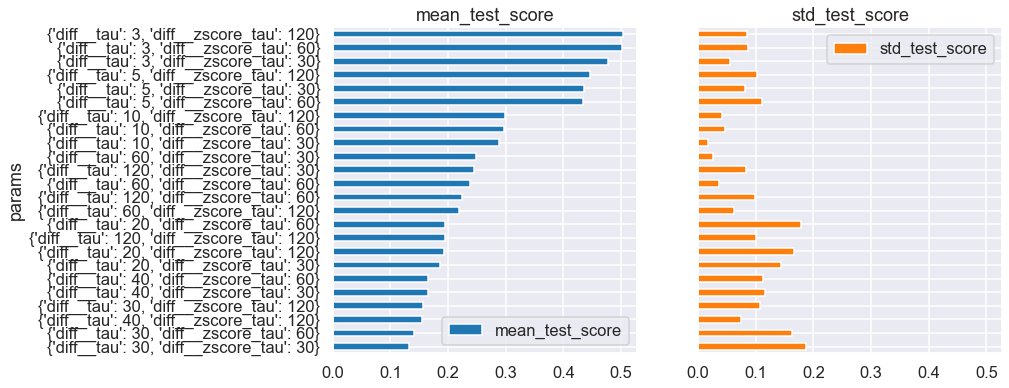

In [53]:
diff_cv_res.sort_values(by='mean_test_score').plot.barh(x='params', y=['mean_test_score', 'std_test_score'], subplots=True, layout=(1,2), sharey=True)
plt.show()

## Evaluation

In [54]:
fte_diff = mle_ts.Diff(tau=3, zscore_tau=30)
comm_df['x_brent_diff_hpt'] = fte_diff.fit_transform(comm_df[['brent']]).values[:,0]

In [55]:
comm_df[['x_brent_diff_hpt', 'target']].corr('spearman')

,x_brent_diff_hpt,target
x_brent_diff_hpt,1.0000,0.4855
target,0.4855,1.0000


In [56]:
pd.crosstab(comm_df['x_brent_diff_hpt']>0, comm_df['target']>0, normalize=True)

target,False,True
x_brent_diff_hpt,,
False,0.2994,0.2205
True,0.1232,0.3569


# Volatility

In [57]:
lr = LinearRegression(fit_intercept=False)
fte_volat = mle_ts.Volatility()
discr = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
pl_volat = Pipeline([('diff', fte_volat), ('discr', discr), ('lr', lr)])

grid_volat = {'volat__tau': [5, 10, 20, 30, 40, 60, 90],
             'volat__zscore_tau': [30, 60, 120]}

volat_cv = GridSearchCV(pl_volat, grid_diff, scoring=spearman_scorer, cv=tscv, n_jobs=-1)
volat_cv.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             estimator=Pipeline(steps=[('diff', Volatility()),
                                       ('discr',
                                        KBinsDiscretizer(encode='ordinal',
                                                         n_bins=10,
                                                         strategy='uniform')),
                                       ('lr',
                                        LinearRegression(fit_intercept=False))]),
             n_jobs=-1,
             param_grid={'diff__tau': [3, 5, 10, 20, 30, 40, 60, 120],
                         'diff__zscore_tau': [30, 60, 120]},
             scoring=make_scorer(compute_spearman))

In [58]:
volat_cv_res = pd.DataFrame(volat_cv.cv_results_)
volat_cv_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_diff__tau,param_diff__zscore_tau,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.0130,0.0008,0.0100,0.0000,3,30,"{'diff__tau': 3, 'diff__zscore_tau': 30}",-0.1020,-0.0907,0.0170,-0.0585,0.0536,6
1,0.0160,0.0028,0.0130,0.0028,3,60,"{'diff__tau': 3, 'diff__zscore_tau': 60}",-0.1153,-0.0920,-0.0109,-0.0727,0.0448,8
2,0.0243,0.0133,0.0156,0.0046,3,120,"{'diff__tau': 3, 'diff__zscore_tau': 120}",-0.1193,-0.0667,-0.0236,-0.0698,0.0391,7
3,0.0153,0.0019,0.0160,0.0078,5,30,"{'diff__tau': 5, 'diff__zscore_tau': 30}",-0.0720,-0.0375,-0.0588,-0.0561,0.0142,5
4,0.0170,0.0042,0.0113,0.0009,5,60,"{'diff__tau': 5, 'diff__zscore_tau': 60}",-0.0951,-0.0774,-0.0801,-0.0842,0.0078,9


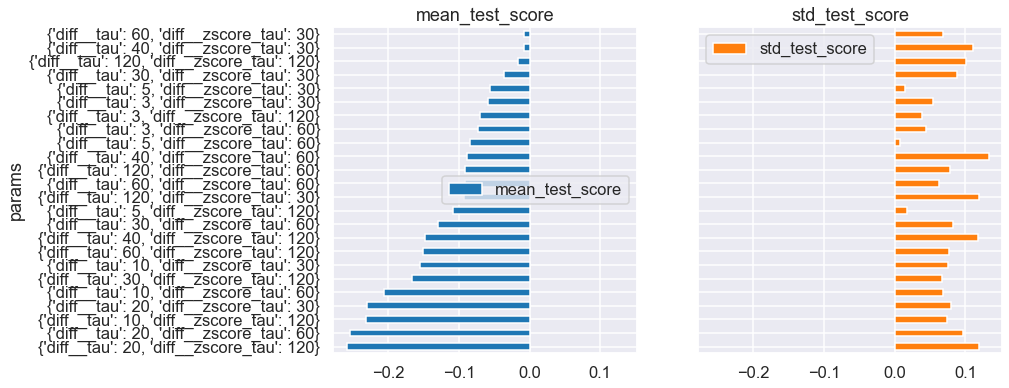

In [59]:
volat_cv_res.sort_values(by='mean_test_score').plot.barh(x='params', y=['mean_test_score', 'std_test_score'], subplots=True, layout=(1,2), sharey=True)
plt.show()

## Evaluation

In [60]:
fte_volat = mle_ts.Volatility(tau=10, zscore_tau=60)
comm_df['x_brent_volat_hpt'] = fte_volat.fit_transform(comm_df[['brent']]).values[:,0]

In [61]:
comm_df[['x_brent_volat_hpt', 'target']].corr('spearman')

,x_brent_volat_hpt,target
x_brent_volat_hpt,1.0000,-0.1188
target,-0.1188,1.0000


In [62]:
pd.crosstab(comm_df['x_brent_volat_hpt']>0, comm_df['target']>0, normalize=True)

target,False,True
x_brent_volat_hpt,,
False,0.2035,0.3304
True,0.2190,0.2471


# Feature Ranking